In [178]:
import numpy as np
import matplotlib.pyplot as plt
import os 
from pyswarm import pso
plt.style.use('presentation.mplstyle') # copy simlink from this folder
%matplotlib notebook
colors_cycle=plt.rcParams.get('axes.prop_cycle')
colors = [item['color'] for item in colors_cycle]

## Transient test

<IPython.core.display.Javascript object>


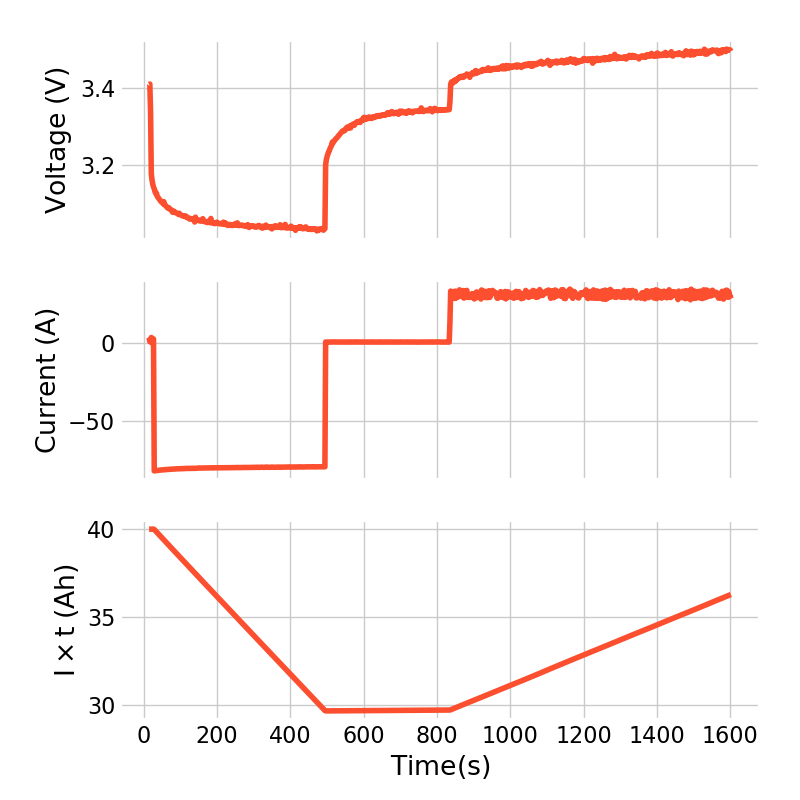

In [179]:
folder = 'Descarga1'
files = os.listdir(os.path.join('.',folder))
files_sorted = sorted(files)
data_list = []
for item in files_sorted:
    data_list += [np.loadtxt(os.path.join('.',folder,item), delimiter=',')]
data = np.vstack(data_list)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex = True)

axes[0].plot(data[:,0], data[:,1])
axes[1].plot(data[:,0], data[:,2])
axes[2].plot(data[:,0], data[:,3])
axes[0].set_ylabel('$\sf Voltage\; (V)$')
axes[1].set_ylabel('$\sf Current\; (A)$')
axes[2].set_ylabel('$\sf I \\times t\; (Ah)$')
#plt.xticks(rotation=30)

axes[2].set_xlabel('$\sf Time (s)$')
#axes[0].set_ylim([0,12])

fig.savefig('out.svg', bbox_inches='tight')

### Manual parammeters

In [188]:
DI = 79.0
V_0 = 3.03
V_1 = 3.21
V_2 = 3.33
tau = 60.0

R_0 = (V_2-V_1)/DI
R_0_1 = (V_2-V_0)/DI
R_1 = R_0_1 - R_0
C_1 = tau/R_1

### PSO parameters

In [190]:
idx_ini = np.argmax(data[:,0]>470)
idx_end = np.argmax(data[:,0]>824)

T = data[idx_ini:idx_end,0] - data[idx_ini,0]
V_t = data[idx_ini:idx_end,1]
I   = -data[idx_ini:idx_end,2]

E = V_2
def f_eval(T,I,x):
    R_0 = x[0]
    R_1 = x[1]
    C_1 = x[2]
    E   = x[3] 
    
    V_t_list = []
    v_c1 = R_1*I[0]
    for it in range(len(T)-1):
        dv_c1 = 1/C_1 * (I[it] - v_c1/R_1)
        Dt = T[it+1]-T[it]
        v_c1 = v_c1 + Dt*dv_c1
        v_t = E - R_0*I[it] - v_c1
        V_t_list += [v_t]
    V_t_ = np.array(V_t_list)
    return V_t_
    
def obj(x):
    
    V_t_ = f_eval(T,I,x)
    
    error = V_t_ - V_t[0:-1]
    return np.sum(error**2)
        

In [191]:
x_0 = np.array([R_0,R_1,C_1,V_2])
lb = x_0*0.5
ub = x_0*2.0

xopt, fopt = pso(obj, lb, ub, minfunc=1e-12, minstep=1e-12, maxiter=500)
xopt
fopt
print('R_0 = ',xopt[0])
print('R_1 = ',xopt[1])
print('C_1 = ',xopt[2])

Stopping search: Swarm best objective change less than 1e-12
R_0 =  0.00206732473453
R_1 =  0.00174134896562
C_1 =  29358.4107982


### Validation

In [192]:
V_t_ = f_eval(data[:,0], -data[:,2],xopt)

<IPython.core.display.Javascript object>


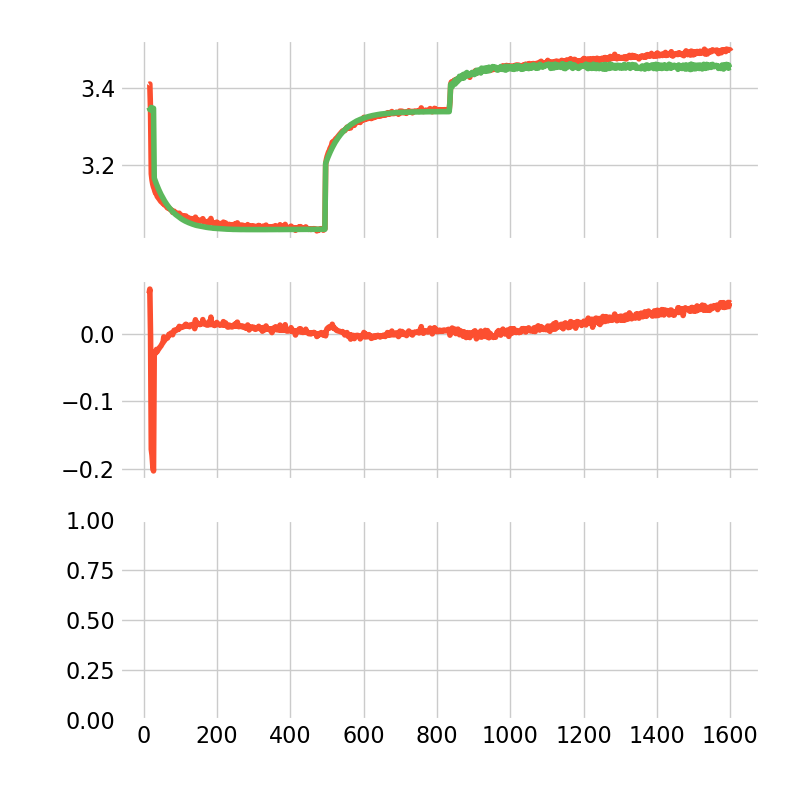

In [193]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex = True)

axes[0].plot(data[:,0], data[:,1])
axes[0].plot(data[0:-1,0], V_t_)
axes[1].plot(data[0:-1,0], data[0:-1,1]-V_t_)
fig.savefig('out.svg', bbox_inches='tight')

In [23]:
0.07552942504871929, 4.203576482588802
2.0138590730764516, 4.125471698113208
6.303451214416302, 4.010159431603765
10.558433532796252, 3.9010653430062483
14.813340657146144, 3.7970968136927863
19.067717217193696, 3.7292939052903233
23.32180044250488, 3.681485996229241
27.5758010895141, 3.639306991244098
31.829858106922934, 3.593285529286275
36.084038078193004, 3.5388829856852895
36.89703713180973, 3.533018867924529
40.33856720337084, 3.4606805599351
41.95151754112942, 3.3971698113207554
42.92694582220798, 3.2841135244330797


(42.92694582220798, 3.2841135244330797)

## Discharge test

<IPython.core.display.Javascript object>


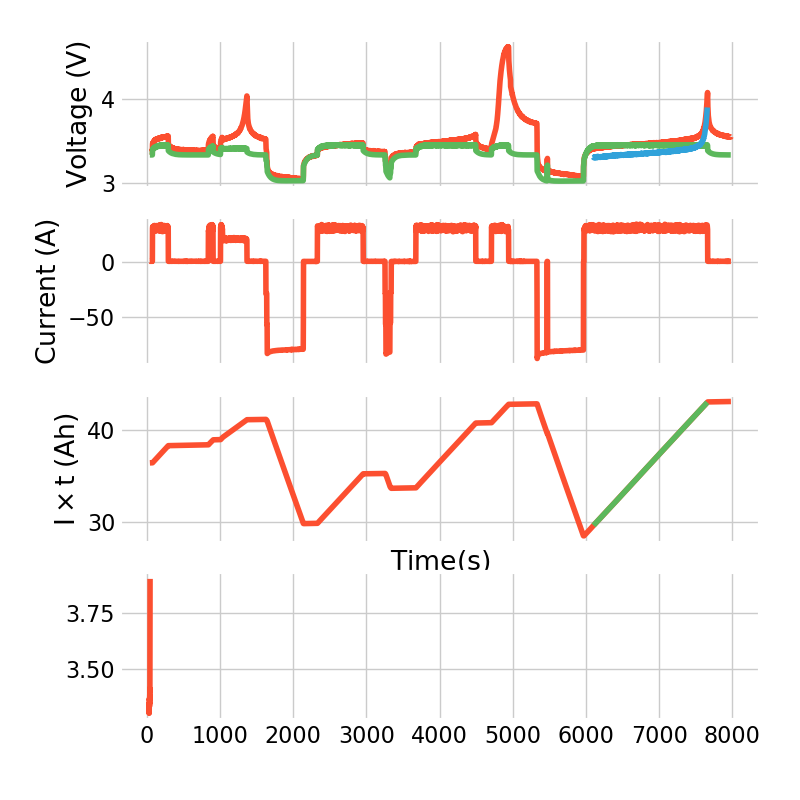

In [195]:
folder = 'CargaFondo2'
files = os.listdir(os.path.join('.',folder))
files_sorted = sorted(files)
data_list = []
for item in files_sorted:
    data_list += [np.loadtxt(os.path.join('.',folder,item), delimiter=',')]
data = np.vstack(data_list)


V_t_ = f_eval(data[:,0], -data[:,2],xopt) 

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex = True)

axes[0].plot(data[:,0], data[:,1])
axes[0].plot(data[0:-1,0], V_t_)
axes[1].plot(data[:,0], data[:,2])
axes[2].plot(data[:,0], data[:,3])

e = (data[0:-1,1]-V_t_)+3.339
idx_ini = np.argmax(data[:,0]>6102)
idx_end = np.argmax(data[:,0]>7659)

axes[2].plot(data[idx_ini:idx_end,0], data[idx_ini:idx_end,3])
axes[0].plot(data[idx_ini:idx_end,0], e[idx_ini:idx_end])

e_prev = 0.0
for it in range(len(e[idx_ini:idx_end])):
    if abs(e[idx_ini:idx_end][it]-e_prev)>0.05:
        #print(data[idx_ini:idx_end,3][it],e[idx_ini:idx_end][it])
        e_prev = e[idx_ini:idx_end][it]
    
axes[3].plot(data[idx_ini:idx_end,3], e[idx_ini:idx_end])

axes[0].set_ylabel('$\sf Voltage\; (V)$')
axes[1].set_ylabel('$\sf Current\; (A)$')
axes[2].set_ylabel('$\sf I \\times t\; (Ah)$')
#plt.xticks(rotation=30)

axes[2].set_xlabel('$\sf Time (s)$')
#axes[0].set_ylim([0,12])

fig.savefig('out.svg', bbox_inches='tight')

### Manual discharge curve

In [171]:
soc_ah_e = np.array([
[0.0,3.0],
[5.0,3.28],
[30,3.31],
[36.57,3.35],
[40.6,3.4],
[41.28,3.42],
[42,3.45],
[42.4,3.5],
[42.6,3.57],
[42.87,3.79],
[42.94,3.9]])

### Validation

In [196]:
T = data[:,0]  
V_t = data[:,1]
I   = -data[:,2]

def f_eval(T,I,params,x_0):
    R_0 = params[0]
    R_1 = params[1]
    C_1 = params[2]
    soc_ah   = x[3] 
    
    V_t_list = []
    SOC_As_list = []
    v_c1 = R_1*I[0]
    soc_as = x_0[1]
    for it in range(len(T)-1):
        e = np.interp(soc_as/3600,soc_ah_e[:,0],soc_ah_e[:,1])
        dv_c1 = 1/C_1 * (I[it] - v_c1/R_1)
        dsoc_as = -0.5*(I[it] + I[it+1])
        Dt = T[it+1]-T[it]
        v_c1 = v_c1 + Dt*dv_c1
        soc_as = soc_as + Dt*dsoc_as
        v_t = e - R_0*I[it] - v_c1
        V_t_list += [v_t]
        SOC_As_list += [soc_as]
    V_t_ = np.array(V_t_list)
    SOC_As_ = np.array(SOC_As_list)
    return V_t_,SOC_As_

x_0 = np.array([0.0,36.4*3600])
V_t_,SOC_As = f_eval(data[:,0], -data[:,2],xopt,x_0) 

<IPython.core.display.Javascript object>


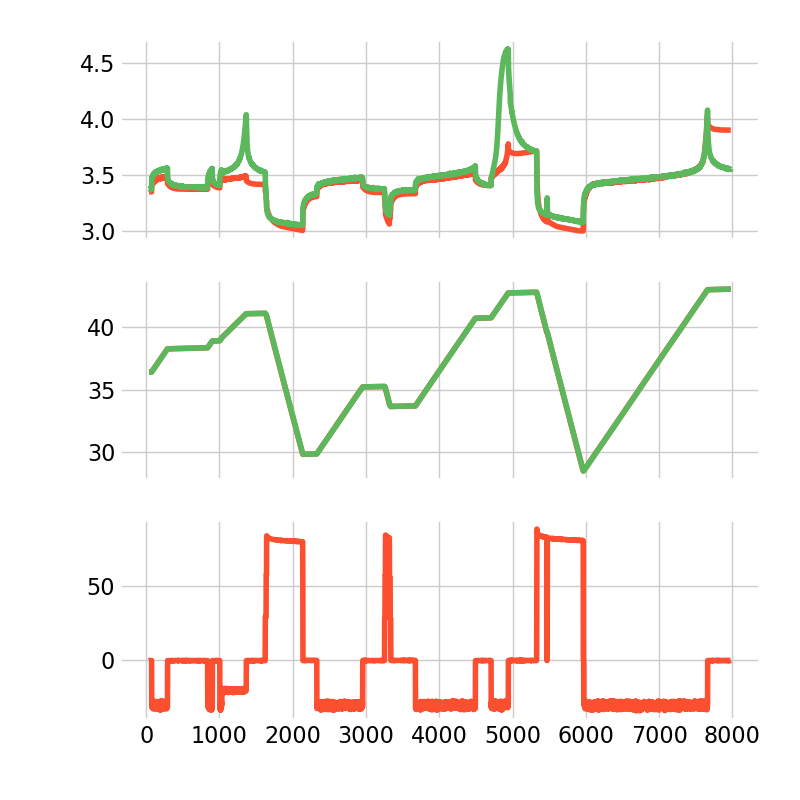

In [197]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex = True)

axes[0].plot(data[0:-1,0],V_t_)
axes[0].plot(data[:,0],data[:,1])
axes[1].plot(data[0:-1,0],SOC_As/3600)
axes[1].plot(data[:,0],data[:,3])
axes[2].plot(T,I)

<IPython.core.display.Javascript object>


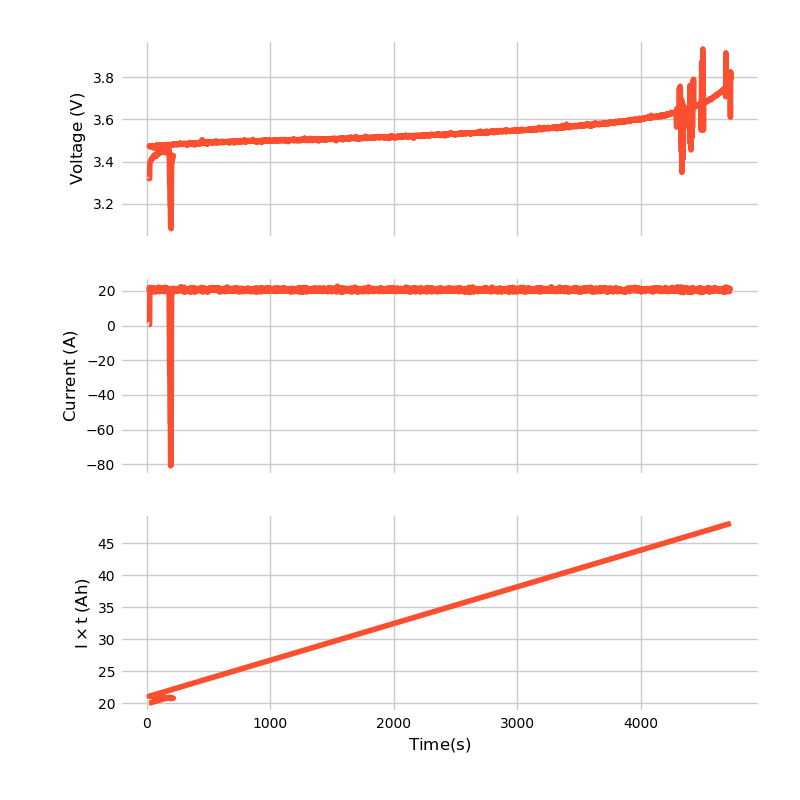

In [29]:
folder = 'CargaFondo'
files = os.listdir(os.path.join('.',folder))
files_sorted = sorted(files)
data_list = []
for item in files_sorted[0:-1]:

    data_arr = np.loadtxt(os.path.join('.',folder,item), delimiter=',')
    data_list += [data_arr]
    
data = np.vstack(data_list)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex = True)

axes[0].plot(data[:,0], data[:,1])
axes[1].plot(data[:,0], data[:,2])
axes[2].plot(data[:,0], data[:,3])
axes[0].set_ylabel('$\sf Voltage\; (V)$')
axes[1].set_ylabel('$\sf Current\; (A)$')
axes[2].set_ylabel('$\sf I \\times t\; (Ah)$')
#plt.xticks(rotation=30)

axes[2].set_xlabel('$\sf Time (s)$')
#axes[0].set_ylim([0,12])

fig.savefig('out.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


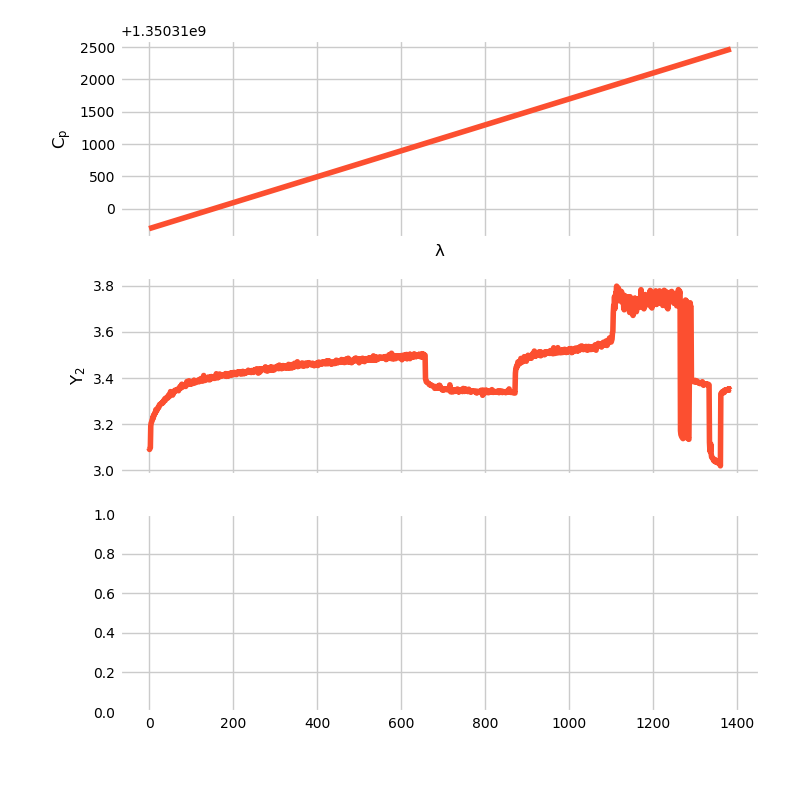

In [30]:
folder = 'Meas2'
files = os.listdir(os.path.join('.',folder))
files_sorted = sorted(files)
data_list = []
for item in files_sorted:
    data_list += [np.loadtxt(os.path.join('.',folder,item), delimiter=',')]
data = np.vstack(data_list)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex = True)

x = np.linspace(0,12,100)
y_1 = np.sin(x)
y_2 = np.cos(x)
axes[0].plot(data[:,0])
axes[1].plot(data[:,1])
#axes[2].plot(data[:,0], data[:,3])
axes[0].set_ylabel('$\sf Y_1$')
axes[1].set_ylabel('$\sf Y_2$')

#plt.xticks(rotation=30)
axes[0].set_ylabel('$\sf C_p$')
axes[0].set_xlabel('$\sf \lambda$')
#axes[0].set_ylim([0,12])

fig.savefig('out.svg', bbox_inches='tight')

# Model

## Symbolic

In [198]:
import sympy as sym

### Initialization

In [334]:
R_0,R_1,C_1,N_serie,N_parallel = sym.symbols('R_0,R_1,C_1,N_serie,N_parallel')
i_bat,v_t_bat,i_cell,v_t_cell,v_c1,p_dc,E = sym.symbols('i_bat,v_t_bat,i_cell,v_t_cell,v_c1,p_dc,E')
#p_dc = i * v_t
v_t_bat = v_t_cell*N_serie
i_bat = i_cell*N_parallel
eq1 = p_dc/v_t_bat - i_bat
eq2 = E - R_0*i_cell - v_c1 - v_t_cell
eq3 = 1/C_1 * (i_cell - v_c1/R_1)
sol = sym.solve([eq1,eq2,eq3],[v_t_cell,i_cell,v_c1])

In [335]:
P_nom = 100e3
V_nom = 700.0
I_nom = P_nom/V_nom
V_cell_nom = 3.3
I_cell_nom = 40.0

N_serie    = np.ceil(V_nom/V_cell_nom)
N_parallel = np.ceil(I_nom/I_cell_nom)
p_dc = P_nom
R_0 =  0.00206732473453
R_1 =  0.00174134896562
C_1 =  29358.4107982
soc_ah_e = np.array([
[0.0,3.0],
[5.0,3.28],
[30,3.31],
[36.57,3.35],
[40.6,3.4],
[41.28,3.42],
[42,3.45],
[42.4,3.5],
[42.6,3.57],
[42.87,3.79],
[42.94,3.9]])

In [336]:
p_dc = 100.0e3
soc_as = 20.0*3600
E = np.interp(soc_as/3600,soc_ah_e[:,0],soc_ah_e[:,1])

i_cell = (E*N_parallel*N_serie - np.sqrt(N_parallel*N_serie*(E**2*N_parallel*N_serie - 4*R_0*p_dc - 4*R_1*p_dc)))/(2*N_parallel*N_serie*(R_0 + R_1))
v_c1 = i_cell*R_1
v_t_cell = E - R_0*i_cell - v_c1 

v_t_bat = v_t_cell*N_serie
i_bat = i_cell*N_parallel
v_c1_0 = v_c1
print('v_t_bat =', v_t_bat)
print('i_bat =', i_bat)

v_t_bat = 672.307463786
i_bat = 148.741469322


### Running

In [348]:
R_0,R_1,C_1,N_serie,N_parallel = sym.symbols('R_0,R_1,C_1,N_serie,N_parallel')
i_bat,v_t_bat,i_cell,v_t_cell,v_c1,p_dc,E = sym.symbols('i_bat,v_t_bat,i_cell,v_t_cell,v_c1,p_dc,E')
#p_dc = i * v_t
v_t_bat = v_t_cell*N_serie
i_bat = i_cell*N_parallel
eq1 = p_dc/v_t_bat - i_bat
eq2 = E - R_0*i_cell - v_c1 - v_t_cell

sol = sym.solve([eq1,eq2],[v_t_cell,i_cell])

In [349]:
sol

[((N_parallel*N_serie*(E - v_c1) - sqrt(N_parallel*N_serie*(E**2*N_parallel*N_serie - 2*E*N_parallel*N_serie*v_c1 + N_parallel*N_serie*v_c1**2 - 4*R_0*p_dc)))/(2*N_parallel*N_serie),
  (N_parallel*N_serie*(E - v_c1) + sqrt(N_parallel*N_serie*(E**2*N_parallel*N_serie - 2*E*N_parallel*N_serie*v_c1 + N_parallel*N_serie*v_c1**2 - 4*R_0*p_dc)))/(2*N_parallel*N_serie*R_0)),
 ((N_parallel*N_serie*(E - v_c1) + sqrt(N_parallel*N_serie*(E**2*N_parallel*N_serie - 2*E*N_parallel*N_serie*v_c1 + N_parallel*N_serie*v_c1**2 - 4*R_0*p_dc)))/(2*N_parallel*N_serie),
  (N_parallel*N_serie*(E - v_c1) - sqrt(N_parallel*N_serie*(E**2*N_parallel*N_serie - 2*E*N_parallel*N_serie*v_c1 + N_parallel*N_serie*v_c1**2 - 4*R_0*p_dc)))/(2*N_parallel*N_serie*R_0))]

In [350]:
P_nom = 100e3
V_nom = 700.0
I_nom = P_nom/V_nom
V_cell_nom = 3.3
I_cell_nom = 40.0

N_serie    = np.ceil(V_nom/V_cell_nom)
N_parallel = np.ceil(I_nom/I_cell_nom)
p_dc = P_nom
R_0 =  0.00206732473453
R_1 =  0.00174134896562
C_1 =  29358.4107982
soc_ah_e = np.array([
[0.0,3.0],
[5.0,3.28],
[30,3.31],
[36.57,3.35],
[40.6,3.4],
[41.28,3.42],
[42,3.45],
[42.4,3.5],
[42.6,3.57],
[42.87,3.79],
[42.94,3.9]])

In [355]:
sol[0][0].subs('N_parallel*N_serie','N')

(N_parallel*N_serie*(E - v_c1) - sqrt(N_parallel*N_serie*(E**2*N_parallel*N_serie - 2*E*N_parallel*N_serie*v_c1 + N_parallel*N_serie*v_c1**2 - 4*R_0*p_dc)))/(2*N_parallel*N_serie)

In [361]:
p_dc = 100.0e3
soc_as = 20.0*3600
E = np.interp(soc_as/3600,soc_ah_e[:,0],soc_ah_e[:,1])
v_c1 = v_c1_0
i_cell = (N_parallel*N_serie*(E - v_c1) - sqrt(N_parallel*N_serie*(E**2*N_parallel*N_serie - 2*E*N_parallel*N_serie*v_c1 + N_parallel*N_serie*v_c1**2 - 4*R_0*p_dc)))/(2*N_parallel*N_serie*R_0)
v_t_cell = E - R_0*i_cell - v_c1 

v_t_bat = v_t_cell*N_serie
i_bat = i_cell*N_parallel

print('v_t_bat =', v_t_bat)
print('i_bat =', i_bat)


v_t_bat = 672.307463786
i_bat = 148.741469323


In [359]:
i_cell

37.185367330625049

In [360]:
v_t_cell

3.1563730694174317

In [362]:
N_serie

213.0